# Using LSTMs

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import xml
import xml.etree.ElementTree as ET
from torchtext.data import get_tokenizer
from functools import reduce
import torchtext
import torchtext as text
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Helper Functions

- `parse_review` : parses the `.xml` file (dataset) for a given language domain pair and extracts all reviews along with the aspect and sentiment

In [2]:
def parse_review(review: xml.etree.ElementTree.Element) -> list:
            return list(map(lambda sen: (sen.find('text').text, 
                                         tuple(map(lambda op: (op.attrib["category"], 
                                                               op.attrib["polarity"]), 
                                                   sen.find("Opinions").findall('Opinion')) # for all opinions
                                              )),
                            list(filter(lambda sen: sen.find("Opinions"), review.find("sentences").findall("sentence"))))) # only sentences w/ opinion

# Aspect Category Detection
- In this task, we pass to our LSTM model the embedded sentence as input and the aspect associated with each sentence as the label

## Data Preprocessing
- We use our helper functions to parse the XML file, tokenise all the sentences and create vocabularies (for words and for aspects)
- We also assemble the dataset so that it can be accessed and passed to our model to implement the desired tasks

In [3]:
# getting all reviews
class ReviewDataset(Dataset):     
    def __init__(self, path: str): 
        tree = ET.parse(path)
        root = tree.getroot()
        self.reviews = list(map(parse_review, root.findall("Review")))
        self.tokenizer = get_tokenizer("basic_english")
        self.vocab = torchtext.vocab.build_vocab_from_iterator(list(map(lambda review: reduce(lambda x, y: x.union(y),
                                                                                         list(map(lambda sen: self.tokenizer(sen[0]), 
                                                                                                  review)), 
                                                                                         set()), 
                                                                        self.reviews)),
                                                  min_freq=1,
                                                  specials=["<unk>", "<pad>"])
        self.aspects = self.find_aspects()

    def __len__(self):
        return len(self.reviews)
    
    def find_aspects(self):
        aspects = []
        for review in self.reviews:
            for sentence in review:
                for opinion in sentence[1]:
                    if opinion[0] not in aspects:
                        aspects.append(opinion[0])
        print(aspects)
        return aspects

    def __getitem__(self, idx):
        '''Arrange elements for the given index of review so that we can access
        the final label for the review (positive/negatie/neutral),
        list of tokenized sentences for the review, 
        list of aspects for each sentence (one-hot encoded),
        and polarity associated with each label'''
        
        review = {'label' : 0, 'ids' : [], 'aspects' : [], 'aspect_polarity' : []}
        rev_sent = 0
        for sentence in self.reviews[idx]:
            # polarity and aspects
            sentiment_count = 0
            aspects = []
            aspect_polarity = []
            for i in range(len(self.aspects)):
                aspects.append(0)
                aspect_polarity.append(0)
            for opinion in sentence[1]:
                aspect, sentiment = opinion
                idx = self.aspects.index(aspect)
                aspects[idx] = 1
                if sentiment == 'positive':
                    sentiment_count += 1
                    aspect_polarity[idx] = 1
                    rev_sent += 1
                elif sentiment == 'negative':
                    sentiment_count -= 1
                    aspect_polarity[idx] = -1
                    rev_sent -= 1
            review['aspects'].append(aspects)
            review['aspect_polarity'].append(aspect_polarity)
        
            # for the combined sentence         
            # if sentiment_count > 0:
            #     rev_sent += 1
            #     # review['label'].append(1)
            # elif sentiment_count < 0:
            #     rev_sent -= 1
            #     review['label'].append(-1)
            # else:
            #     review['label'].append(0)

            tokenized_sentence = self.tokenizer(sentence[0])
            tokens_to_idx = []
            for token in tokenized_sentence:
                tokens_to_idx.append(self.vocab[token])
            while (len(tokens_to_idx) < 78):
                tokens_to_idx.append(self.vocab["<pad>"])
            review['ids'].append(tokens_to_idx)
        if rev_sent > 0:
            review['label'] = 1
        elif rev_sent < 1:
            review['label'] = -1
        return review

english = ReviewDataset("./datasets/english-restaurants.xml")

pretrained_vectors = text.vocab.GloVe(name='6B', dim=50)
pretrained_embedding = pretrained_vectors.get_vecs_by_tokens(english.vocab.get_itos())

['RESTAURANT#GENERAL', 'SERVICE#GENERAL', 'FOOD#QUALITY', 'FOOD#STYLE_OPTIONS', 'DRINKS#STYLE_OPTIONS', 'DRINKS#PRICES', 'RESTAURANT#PRICES', 'RESTAURANT#MISCELLANEOUS', 'AMBIENCE#GENERAL', 'FOOD#PRICES', 'LOCATION#GENERAL', 'DRINKS#QUALITY']


In [4]:
print(english[3]['label'])

1


In [5]:
def create_sentences(english):
    '''Function to get all sentences from every review as a single list
    in order to carry out training at the sentence-level'''
    
    all_sentences = []
    for i in range(len(english)):
        for j in range(len(english[i]["ids"])):
            all_sentences.append({'text': english[i]["ids"][j], 'aspects': english[i]["aspects"][j]})
    return all_sentences

all_sentences = create_sentences(english)

In [6]:
print(all_sentences[0]["aspects"])

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
max_len_sentence = 0
for review in english.reviews:
    for sentence in review:
        tokenized_sentence = english.tokenizer(sentence[0])
        curr_len = len(tokenized_sentence)
        if (curr_len > max_len_sentence):
            max_len_sentence = curr_len

#### Defining hyperparameters

In [8]:
ASPECTS = english.aspects
MAX_SENTENCE = 100
VOCAB_SIZE = len(english.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 50
LEARNING_RATE = 0.01
BATCH_SIZE = 1
EPOCHS = 10

## LSTM model

In [9]:
class LSTMAspectExtractionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data = pretrained_embedding
        self.lstm = nn.LSTM(input_size=embedding_dim, bidirectional=True, hidden_size=hidden_dim)
        self.l = nn.Linear(2*hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=0)
        self.hidden_dim = hidden_dim
        
    def forward(self, x):
        embedded = self.embedding(torch.tensor(x))
        lstm_out, (hidden, _) = self.lstm(embedded)
        # print(torch.tensor(x).shape, embedded.shape, lstm_out.shape, hidden.shape)
        output = self.l(torch.flatten(hidden))
        # output = self.softmax(output)
        return output
        
model = LSTMAspectExtractionModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, len(ASPECTS))

In [10]:
data_loader = DataLoader(all_sentences, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
def encode_output(outputs, threshold):
    max_index = torch.argmax(outputs)
    outputs = torch.where(outputs > threshold, 1, 0)
    outputs[max_index] = 1
    return(outputs)

In [12]:
import torch

# Assuming you have a 1D tensor
tensor = torch.tensor([1, 2, 3, 1, 4, 1, 5, 1])

# Specify the value you want to count
value_to_find = 1

# Use torch.eq() to create a boolean tensor and then use torch.sum() to count occurrences
count = torch.sum(torch.eq(tensor, value_to_find)).item()

print(f"The value {value_to_find} appears {count} times in the tensor.")


The value 1 appears 4 times in the tensor.


## Training the data

In [16]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

losses = []
accuracies = []

for epoch in tqdm(range(EPOCHS), desc="Training Epochs"):
    epoch_loss = 0
    epoch_correct = 0 
    epoch_total = 0
    
    for i, data in enumerate(data_loader):

        inputs = data["text"]
        labels = torch.tensor(data["aspects"], dtype=torch.float)
        
        count = torch.sum(torch.eq(labels, 1)).item() # number of times 1 appears

        optim.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        top_values, top_indices = torch.topk(outputs, k=count) # find the top tensors

        # Create a one-hot embedding for the top *count* values
        one_hot_embedding = torch.zeros_like(outputs)
        # for it in top_indices:
        #     if 
        one_hot_embedding[top_indices] = 1

        if (torch.equal(one_hot_embedding, labels)):
            epoch_correct += 1
        epoch_total += 1

        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optim.step()
        
        epoch_loss += loss.item()

    losses.append(epoch_loss)
    accuracies.append(100*epoch_correct/epoch_total)
    print(f"Epoch : {epoch+1}/{EPOCHS} | Loss : {epoch_loss:.4f}")
    print(f"Accuracy : {100*epoch_correct/epoch_total}%")

print("Training finished")

Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1/10 | Loss : 2932.8286
Accuracy : 67.79859484777518%
Epoch : 2/10 | Loss : 2464.4723
Accuracy : 73.77049180327869%
Epoch : 3/10 | Loss : 2280.1339
Accuracy : 76.81498829039812%
Epoch : 4/10 | Loss : 2083.3334
Accuracy : 81.08899297423888%
Epoch : 5/10 | Loss : 2026.2803
Accuracy : 82.78688524590164%
Epoch : 6/10 | Loss : 1964.6161
Accuracy : 83.13817330210773%
Epoch : 7/10 | Loss : 1896.3283
Accuracy : 84.54332552693208%
Epoch : 8/10 | Loss : 1915.8267
Accuracy : 83.8407494145199%
Epoch : 9/10 | Loss : 1788.8250
Accuracy : 86.18266978922716%
Epoch : 10/10 | Loss : 1744.9371
Accuracy : 87.9976580796253%
Training finished


## Results obtained

### Train data

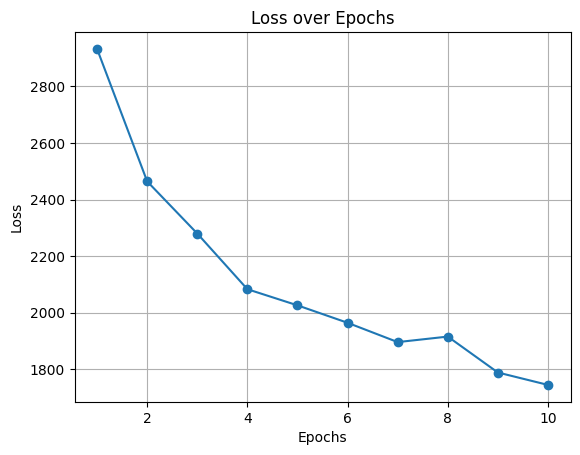

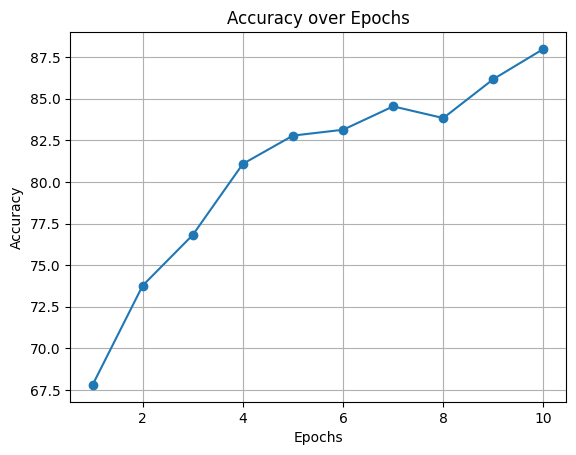

In [17]:
epochs = [(epoch + 1) for epoch in range(EPOCHS)]

# Plotting epochs against loss
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Show grid
plt.show()

# Plotting epochs against accuracy
plt.plot(epochs, accuracies, marker='o', linestyle='-')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)  # Show grid
plt.show()

### Test data

In [20]:
english_test = ReviewDataset("./datasets/english-restaurants.xml")

pretrained_vectors = text.vocab.GloVe(name='6B', dim=50)
pretrained_embedding = pretrained_vectors.get_vecs_by_tokens(english.vocab.get_itos())

['RESTAURANT#GENERAL', 'SERVICE#GENERAL', 'FOOD#QUALITY', 'FOOD#STYLE_OPTIONS', 'DRINKS#STYLE_OPTIONS', 'DRINKS#PRICES', 'RESTAURANT#PRICES', 'RESTAURANT#MISCELLANEOUS', 'AMBIENCE#GENERAL', 'FOOD#PRICES', 'LOCATION#GENERAL', 'DRINKS#QUALITY']


In [21]:
all_sentences_test = create_sentences(english_test)

# inputs = []
# labels = []
correct = 0
total = 0
for sntnc in all_sentences_test:
    # inputs.append(all_sentences_test[i]['text'])
    # labels.append(all_sentences_test[i]["aspects"])

    outputs = model(sntnc['text'])
    # print(outputs)
    top_values, top_indices = torch.topk(outputs, k=count)
    one_hot_embedding = torch.zeros_like(outputs)
    one_hot_embedding[top_indices] = 1
    # print(one_hot_embedding)
    if (torch.equal(one_hot_embedding, torch.tensor(sntnc['aspects']))):
        correct += 1
    total += 1
acc = 100 * correct/total
print("Accuracy on the test set =", acc)

Accuracy on the test set = 71.95550351288057


# Sentiment Polarity Determination

In [22]:
def create_sentences_polarity(english):
    '''Function to get all sentences from every review as a single list
    in order to carry out training at the sentence-level'''
    
    all_sentences = []
    for i in range(len(english)):
        for j in range(len(english[i]["ids"])):
            all_sentences.append({'text': english[i]["ids"][j], 'aspect_polarity': english[i]["aspect_polarity"][j]})
    return all_sentences

all_sentences = create_sentences_polarity(english)

In [24]:
data_loader = DataLoader(all_sentences, batch_size=BATCH_SIZE, shuffle=True)

model = LSTMAspectExtractionModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, 1)

criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

losses = []
accuracies = []

for epoch in tqdm(range(5), desc="Training Epochs"):
    epoch_loss = 0
    epoch_correct = 0 
    epoch_total = 0
    
    for i, data in enumerate(data_loader):
        inputs = data["text"]
        labels = torch.sum(torch.tensor(data["aspect_polarity"], dtype=torch.float)).unsqueeze(0)

        optim.zero_grad()
        
        # Forward pass
        outputs = model(inputs)

        if labels.item() * outputs.item() > 0:
            epoch_correct += 1
        elif labels.item() == outputs.item():
            epoch_correct += 1
        epoch_total += 1

        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optim.step()
        
        epoch_loss += loss.item()

    losses.append(epoch_loss)
    accuracies.append(100*epoch_correct/epoch_total)
    print(f"Epoch : {epoch+1}/{EPOCHS} | Loss : {epoch_loss:.4f}")
    print(f"Accuracy : {100*epoch_correct/epoch_total}%")

print("Training finished")

Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 1/10 | Loss : 1852.3328
Accuracy : 75.05854800936768%
Epoch : 2/10 | Loss : 1071.9263
Accuracy : 85.77283372365339%
Epoch : 3/10 | Loss : 1001.7240
Accuracy : 86.53395784543325%
Epoch : 4/10 | Loss : 781.1707
Accuracy : 88.17330210772833%
Epoch : 5/10 | Loss : 764.8712
Accuracy : 88.34894613583138%
Training finished


## Results obtained

### Train data

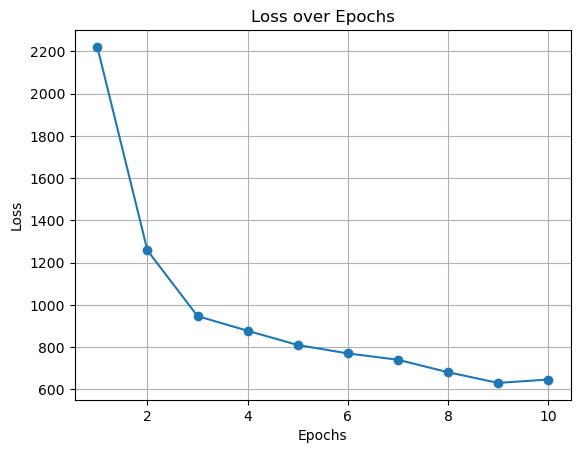

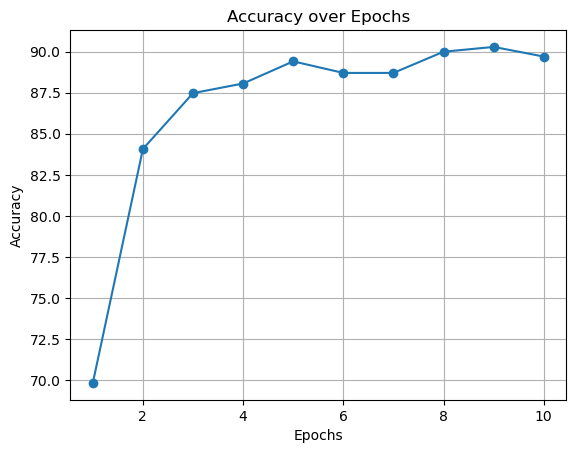

In [16]:
epochs = [(epoch + 1) for epoch in range(EPOCHS)]

# Plotting epochs against loss
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Show grid
plt.show()

# Plotting epochs against accuracy
plt.plot(epochs, accuracies, marker='o', linestyle='-')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)  # Show grid
plt.show()

### Test data

In [18]:
all_sentences_test = create_sentences_polarity(english_test)

# inputs = []
# labels = []
correct = 0
total = 0
for sntnc in all_sentences_test:
    # inputs.append(all_sentences_test[i]['text'])
    # labels.append(all_sentences_test[i]["aspects"])
    labels = torch.sum(torch.tensor(sntnc["aspect_polarity"], dtype=torch.float)).unsqueeze(0)
    outputs = model(sntnc['text'])
    # print(outputs)
    if labels.item() * outputs.item() > 0:
        correct += 1
    elif labels.item() == outputs.item():
        correct += 1
    total += 1
acc = 100 * correct/total
print("Accuracy on the test set =", acc)

Accuracy on the test set = 89.51990632318501
